In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from skimage.feature import peak_local_max

%matplotlib inline

# Question 01

In [22]:
def laplace_of_gaussian(sigma):
    # Calculate kernel half-width
    hw = int(3 * sigma)
    
    # Create 2D coordinate grid
    x = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, x)
    
    # Precompute common terms for clarity
    norm_factor = 1 / (np.pi * sigma**4)
    exp_term = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    scale_term = (X**2 + Y**2) / (2 * sigma**2) - 1
    
    # Calculate Laplacian of Gaussian
    log = norm_factor * scale_term * exp_term
    
    return log

In [23]:
def detect_max(img_log, sigma):
    coordinates = set()
    k = 1  # Radius for neighborhood
    threshold = 0.09

    # Get the dimensions of the image
    h, w = img_log.shape

    # Iterate over the valid region to avoid boundary issues
    for i in range(k, h - k):
        for j in range(k, w - k):
            # Extract the local neighborhood
            patch = img_log[i - k:i + k + 1, j - k:j + k + 1]
            
            # Check if the max value meets the threshold
            if patch.max() >= threshold:
                # Get the coordinates of the max value within the patch
                x, y = np.unravel_index(np.argmax(patch), patch.shape)
                # Adjust to the image's coordinate space and store the result
                coordinates.add((i + x - k, j + y - k))
    
    return coordinates

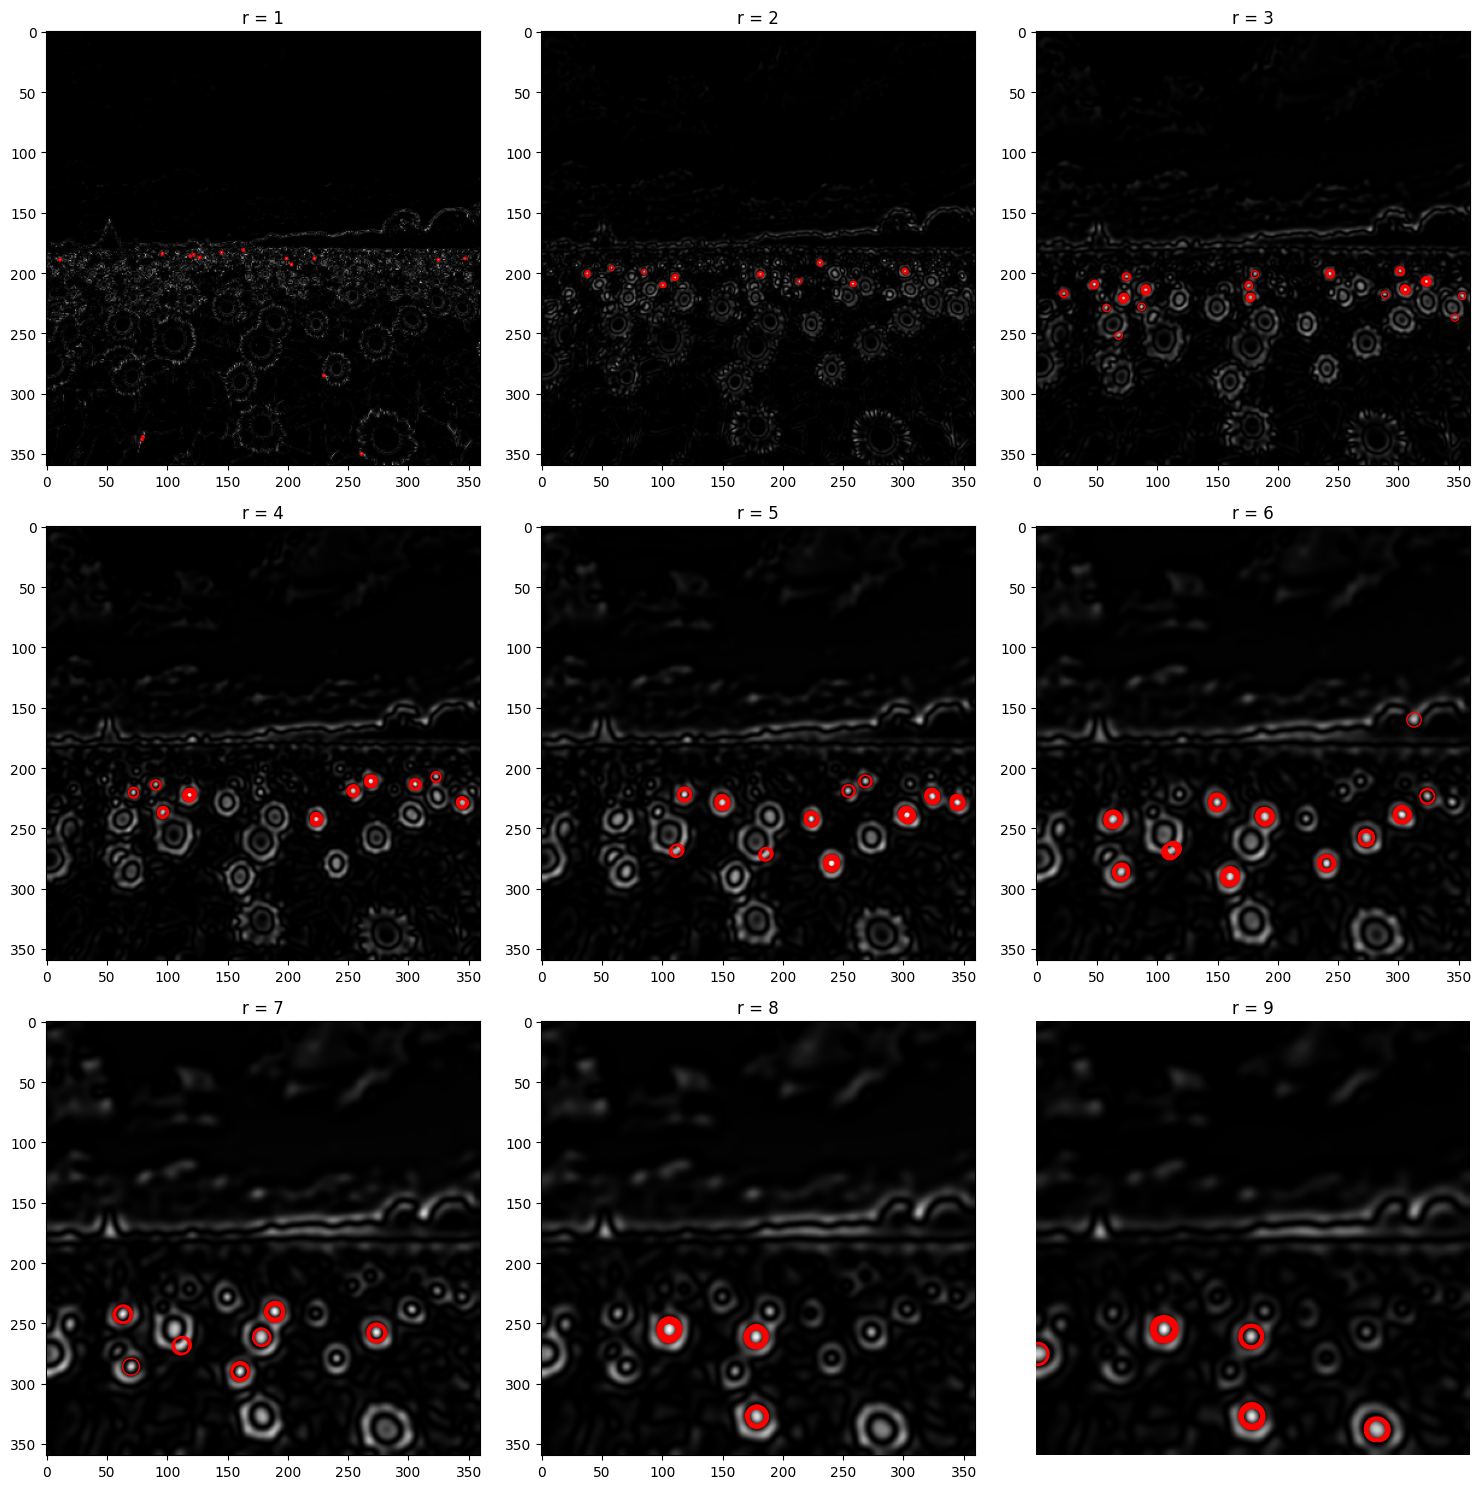

In [34]:
# Load and preprocess the image
img1 = cv.imread("D:/Sem 5/Image Processing and Machine Vision/Github/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255.0

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over each subplot to apply LoG filtering and detect local peaks
for r, ax in enumerate(axes.flatten(), start=1):
    sigma = r / 1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)  # Compute the LoG kernel
    
    # Apply LoG filter and square the result
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    # Detect local peaks
    coordinates = detect_max(img1_log, sigma)

    # Display the LoG-filtered image
    ax.imshow(img1_log, cmap='gray')
    ax.set_title(f'r = {r}')

    # Draw circles around detected peaks
    for x, y in coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

# Adjust layout and remove axis ticks for a cleaner look
plt.tight_layout()
plt.axis('off')
plt.show()

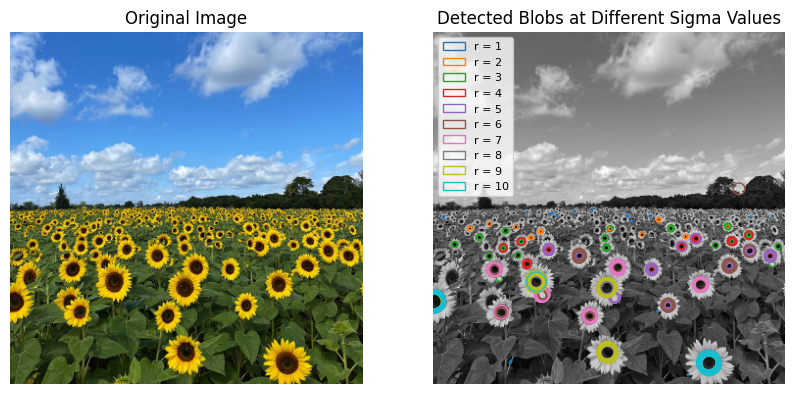

In [36]:
# Load the image and convert to grayscale
img1 = cv.imread('D:/Sem 5/Image Processing and Machine Vision/Github/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY).astype(np.float32) / 255.0

# Set up the plotting canvas
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Display original image
axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display grayscale image with detected blobs
ax = axes[1]
ax.imshow(img1_gray, cmap='gray')
ax.grid(False)
colors = list(mcolors.TABLEAU_COLORS.values())  # Use color values directly

# Initialize variables to store legend details
patches, labels = [], []

# Loop through different sigma values to detect blobs
for r in range(1, 11):
    sigma = r / 1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)  # Create LoG kernel
    img1_log = np.square(cv.filter2D(img1_gray, -1, LOG))  # Apply LoG filter

    coordinates = detect_max(img1_log, sigma)  # Detect local maxima

    # Plot detected blobs as circles
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color=colors[r-1], linewidth=1, fill=False)
        ax.add_patch(c)
    
    # Store patch and label for legend
    patches.append(c)
    labels.append(f'r = {r}')

# Final plot adjustments
ax.set_xlim(0, img1.shape[1])
ax.set_title("Detected Blobs at Different Sigma Values")
ax.legend(patches, labels, loc='best', fontsize=8)
plt.axis('off')

plt.show()

# Question 02

In [41]:
!pip install tikzplotlib==0.9.8

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: tikzplotlib
    Found existing installation: tikzplotlib 0.10.1
    Uninstalling tikzplotlib-0.10.1:
      Successfully uninstalled tikzplotlib-0.10.1


In [42]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center

s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground Truth Line')
plt.legend()

ModuleNotFoundError: No module named 'tikzplotlib'